In [12]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import face_recognition
import numpy as np
import pickle
import os


In [13]:
# Load the existing encodings
face_encoding_path = r'..\face_recognition\face_encodings.pkl'
with open(face_encoding_path, "rb") as f:
    data = pickle.load(f)

In [14]:
known_face_encodings = data["encodings"]
known_face_names = data["names"]

In [15]:
# Function to create a slight modification to an encoding
def perturb_encoding(encoding, noise_level=0.01):
    """ Perturb a face encoding slightly to change its characteristics. """
    noise = np.random.normal(0, noise_level, size=encoding.shape)
    return encoding + noise

In [16]:
# Example of modifying a specific person's encoding
def poison_encoding(target_name, new_name=None, noise_level=0.01):
    for i, name in enumerate(known_face_names):
        if name == target_name:
            # Perturb the encoding to match another name or create ambiguity
            known_face_encodings[i] = perturb_encoding(known_face_encodings[i], noise_level)
            if new_name:
                # Optionally change the associated name
                known_face_names[i] = new_name


In [17]:
# Poison the encoding for a specific target
target_name = "Alex Stevenson"
poison_encoding(target_name, new_name="Emily Stevenson")


In [18]:
# Save the poisoned encodings back to the pickle file
data["encodings"] = known_face_encodings
data["names"] = known_face_names
with open(r"poisoned_face_encodings.pkl", "wb") as f:
    pickle.dump(data, f)

# Output Poisoned Samples

In [21]:
# Load the known face encodings and names from the poisoned pickle file
with open(r"poisoned_face_encodings.pkl", "rb") as f:
    data = pickle.load(f)

known_face_encodings = data["encodings"]
known_face_names = data["names"]

test_img_path = r'..\img\test_img'

In [22]:
def identify_face(imgpath):
    # Load the unknown image
    unknown_image = face_recognition.load_image_file(imgpath)
    
    face_locations = face_recognition.face_locations(unknown_image)
    face_encodings = face_recognition.face_encodings(unknown_image, face_locations)
    
    # Convert the image to a PIL-format image so that we can draw on top of it with the Pillow library
    pil_image = Image.fromarray(unknown_image)
    # Create a Pillow ImageDraw Draw instance to draw with
    draw = ImageDraw.Draw(pil_image)
    
    # Loop through each face found in the unknown image
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
        # See if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)

        name = "Unknown"

        # Use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = known_face_names[best_match_index]

        # Draw a box around the face using the Pillow module
        draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

        # Load a font
        font = ImageFont.load_default()

        # Calculate text size using textbbox
        text_size = draw.textbbox((left, bottom), name, font=font)
        text_width = text_size[2] - text_size[0]
        text_height = text_size[3] - text_size[1]

        # Draw a label with a name below the face
        draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
        draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255), font=font)
        
    # Remove the drawing library from memory as per the Pillow docs
    del draw
        
    return pil_image

In [23]:
def visualize_poisoned_images():
    for file_name in os.listdir(test_img_path):
        file_path = os.path.join(test_img_path, file_name)
        identified_image = identify_face(file_path)
        display(identified_image)

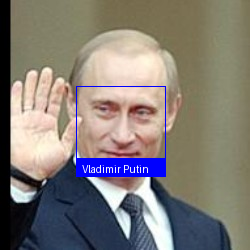

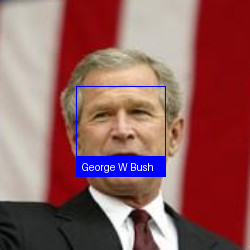

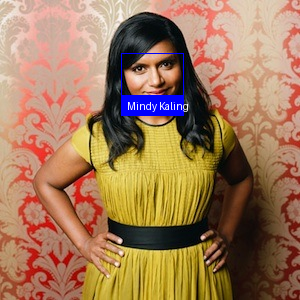

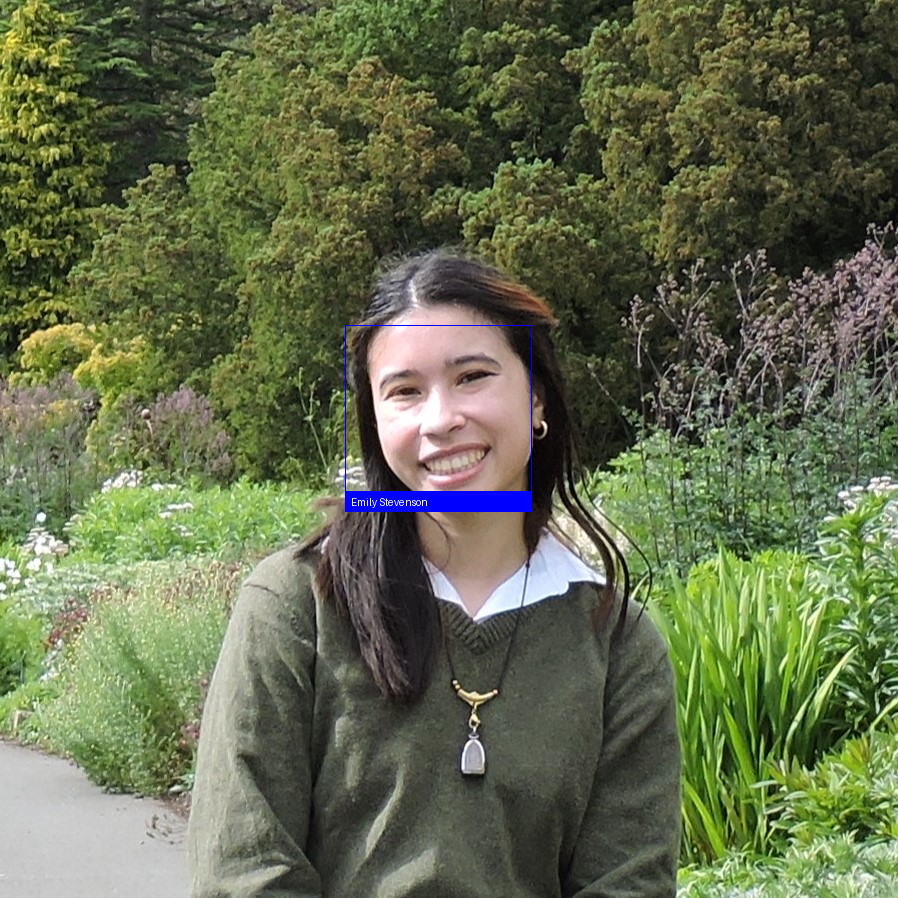

In [24]:
# Display images affected by the poisoned encodings
visualize_poisoned_images()